In [1]:
# initialize stuff
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [3]:
from utilities.constants import G_0_muS

V = np.linspace(-3, 3, 501, dtype="float64")
dV = (np.max(V) - np.min(V)) / (V.shape[0] - 1)

tau = 0.5
G_N = 0.1
Delta_meV = 0.18
gamma_meV = 1e-4  # 1e-1
T_K = 0.1
A_mV = 0.1
nu_GHz = 20.0

V_mV = V * Delta_meV
dV_mV = dV * Delta_meV

from models.bcs import Delta_meV_of_T

Delta_T_meV = Delta_meV_of_T(Delta_meV=Delta_meV, T_K=T_K)

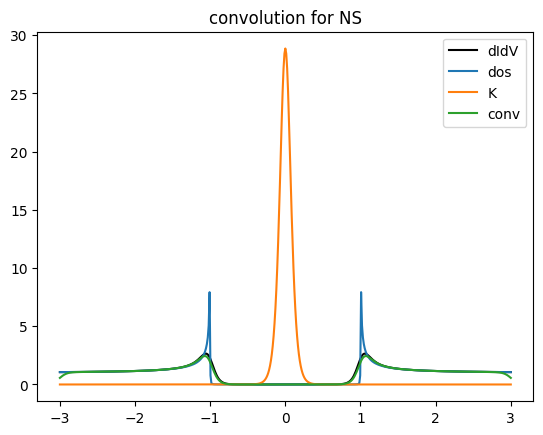

In [4]:
# show convolution
from models.bcs import N_of_E, f_of_E, get_I_nA


def K_of_E(E_meV, T_K):
    return -1 * np.gradient(f_of_E(E_meV=E_meV, T_K=T_K), E_meV)


K = K_of_E(E_meV=V_mV, T_K=T_K)

N_S = N_of_E(E_meV=V_mV, Delta_meV=Delta_T_meV, gamma_meV=gamma_meV)
G_NS = np.convolve(N_S, K, mode="same") * dV_mV

I_NS = get_I_nA(
    V_mV=V_mV,
    Delta_meV=(0.0, Delta_meV),
    G_N=G_N,
    T_K=T_K,
    gamma_meV=gamma_meV,
)
dIdV_NS = np.gradient(I_NS, V_mV) / G_0_muS / G_N

plt.plot(V, dIdV_NS, "k", label="dIdV")
plt.plot(V, N_S, label="dos")
plt.plot(V, K, label="K")
plt.plot(V, G_NS, label="conv")
plt.title("convolution for NS")
plt.legend()

In [5]:
from utilities.constants import G_0_muS

V = np.linspace(-10, 10, 10001, dtype="float64")
dV = (np.max(V) - np.min(V)) / (V.shape[0] - 1)

tau = 0.5
G_N = 0.1
Delta_meV = 0.18
gamma_meV = 1e-4  # 1e-1
T_K = 0.5
A_mV = 0.1
nu_GHz = 20.0

V_mV = V * Delta_meV
dV_mV = dV * Delta_meV

from models.bcs import Delta_meV_of_T

Delta_T_meV = Delta_meV_of_T(Delta_meV=Delta_meV, T_K=T_K)
Delta2_T_meV = Delta_meV_of_T(Delta_meV=Delta_meV * 0.5, T_K=T_K)

In [6]:
from models.bcs_jnp import get_I_nA

I_SS = get_I_nA(
    V_mV=V_mV,
    Delta_meV=(Delta_meV, Delta_meV * 0.5),
    G_N=G_N,
    T_K=T_K,
    gamma_meV=gamma_meV,
)
dIdV_SS = np.gradient(I_SS, V_mV) / G_0_muS / G_N

INFO:2026-01-27 12:02:20,509:jax._src.xla_bridge:812: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/oliver/.pyenv/versions/3.13.3/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/oliver/.pyenv/versions/3.13.3/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/oliver/.pyenv/versions/3.13.3/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/oliver/.pyenv/versions/3.13.3/lib/libtpu.so' (no suc

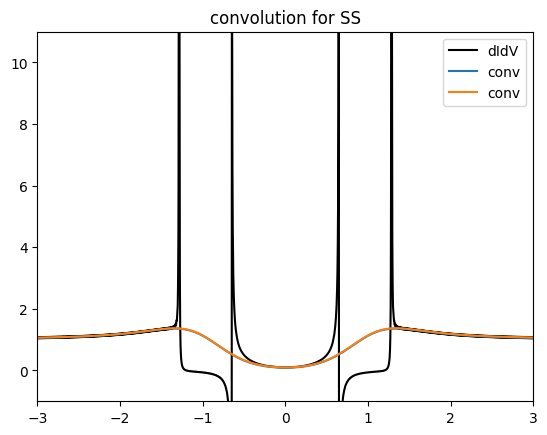

In [8]:
# show convolution SS
from models.bcs import N_of_E, f_of_E

f_1 = f_of_E(E_meV=+V_mV, T_K=T_K)
N_1 = N_of_E(E_meV=+V_mV, Delta_meV=Delta_T_meV, gamma_meV=gamma_meV)
f_2 = f_of_E(E_meV=+V_mV, T_K=T_K)
N_2 = N_of_E(E_meV=+V_mV, Delta_meV=Delta2_T_meV, gamma_meV=gamma_meV)
N_2 = np.ones_like(V_mV)

dN_1 = np.gradient(N_1, V_mV)
dN_2 = np.gradient(N_2, V_mV)
df_1 = np.gradient(f_1, V_mV)
df_2 = np.gradient(f_2, V_mV)

G_SS = +np.convolve(N_2 * (1 - f_2), N_1, mode="same") * dV_mV
G_SS -= np.convolve(N_1 * (0 + f_1), N_2, mode="same") * dV_mV
G_SS *= G_0_muS * G_N

G_SS = np.gradient(G_SS, V_mV) / G_0_muS / G_N
# G_SS = np.abs(G_SS)

g_ss = +np.convolve(N_2 * (1 - f_2), dN_1, mode="same") * dV_mV
g_ss -= np.convolve(N_1 * (0 + f_1), dN_2, mode="same") * dV_mV
g_ss += 1

g_s = +np.convolve(dN_2 * (1 - f_2) + N_2 * -df_1, N_1, mode="same") * dV_mV
g_s -= np.convolve(dN_1 * (0 + f_1) + N_1 * +df_2, N_2, mode="same") * dV_mV
g_s -= 1
# g_s = np.abs(g_s)

# g_s2 = +np.convolve(dN_2 * f_2, N_1, mode="same") * dV_mV
# g_s2 -= np.convolve(dN_1 * f_1, N_2, mode="same") * dV_mV
# g_s2 -= 1

# plt.plot(V, I_SS)
plt.plot(V, dIdV_SS, "k", label="dIdV")
# plt.plot(V, N_S1, label="dos")
# plt.plot(V, N_S2, label="dos")
# plt.plot(V, I_SS, label="I_theo")
# plt.plot(V, G_SS, label="conv")
plt.plot(V, g_ss, label="conv")
plt.plot(V, g_s, label="conv")
# plt.plot(V, g_s2, label="conv")
# plt.plot(V, np.convolve(dN_2 * f_2 + N_2 * df_2, N_1, mode="same") * dV_mV)
# plt.plot(V, dN_1, label="conv")
plt.title("convolution for SS")
plt.xlim(-3, 3)
plt.ylim(-1, 11)
plt.legend()